<center><h1> PyF2F - Image Registration Notebook </h1></center>

To achieve accurate distance measurements between two fluorophores that emit at different wavelengths, it is crucial to register the positions of the two fluorophores obtained in the two channels. This notebook runs the functionalities of PyF2F to calculate the chromatic shift between the two color positions (corresponding to the the two channels) over the entire field of view at the nanometer scale.

### Scientific IPython Setup

Before starting, we need to :
1. Scientific IPython Setup
2. Set parameters to run the image registration workflow
3. Set paths to working directories

<h3>1. Scientific IPython Setup </h3>

Load some required scientific Python libraries:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg
import os
import glob
import shutil
import sys
import time
import pandas as pd
import numpy as np
import trackpy as tp
import pims
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tkinter as tk
from tkinter import filedialog
from skimage import io, util
from skimage import data
from scipy import stats
from scipy import spatial
from pymicro.view.vol_utils import compute_affine_transform
from matplotlib import rcParams

as well as PyF2F-Ruler's custom functions:

In [2]:
# Append PyF2F scripts path and import functions
sys.path.append('/'.join(os.getcwd().split("/")[:-1]) + '/scripts/')
from detect_beads import *
%aimport detect_beads

<h3>2. Parameters for Image Registration </h3>

Now, we have to set the **parameters** to run the image registration workflow. PyF2F calculates the registration map between the two channels using a *piecewise affine transformation*, correcting spot positions locally using nearby fiducial points.

Important parameters here are the **pixel size** of the camera (*nm/px*) and the **spot diameter** (aproximate the spot size to the PSF of the microscope, actually the diameter should approximate twice the PSF of the microscope). 

The rest of the parameters help to optimize the spot detection based on intensity filters such as the **percentile** (detecting spots above a given percentile), the **mass (integrated brightness)**  (avoiding selecting low-intense spots or too high-intense spots (such as bead aggreagates). Moreover, since the local affine correction is based on a nearest-neighbor search, two parameters can influence the registration outcome: minimum number of fiducial points (**min_fiducials ~ 100**) and maximum distance to the coordinate to correct (**search_range ~ 2 $\mu m$**).

In [8]:
beads_head = "*.tif"            # Beads_head (pattern in bead images)
px_size = 64.5                   # Zyla camera (64.5 nm/px) // Prime camera (110 nm/px) 
db_PSF = 700                    # Double size of the PSF to calculate the spot diameter
if px_size == 64.5:             # spot detection: diameter of spots in px
    spot_diameter = 11          # Spot size Zyla
elif px_size == 110:
    spot_diameter = 7           # Spot size Prime
percentile = 99.8               # spot detection: sort spots below this percentile of intensity 
min_mass = 0.01                 # spot detection: sort spots with a mass above this threshold (range 0-1). 
max_mass = 0.95                 # spot detection: sort spots with a mass below this threshold (range 0-1).
max_displacement=1              # linking: link spots from ch1-ch2 channels separated by this cutoff in px
search_range = 2000 // px_size  # local registration: max distance in px for nearest-neighbour search
min_fiducials = 10              # local registration: minimum number of fiducial markers to correct locally 

In [9]:
spot_diameter

11

<h3>3. Set paths to your working directories </h3>

The last thing to go is setting the paths to the working directories. At least we should have two different directories:

- Directory with beads images to create the registration map (Beads_reg)
- Directory with beads images to calculate the error of registration (Beads_test)
- Diretory to output of registration
- Directory to outout of test

In [18]:
# Select directories where Beads_reg and Beads_test
root = tk.Tk()
root.withdraw()
path_beads_reg = filedialog.askdirectory(title="Select Directory Beads Registration") + "/"
path_beads_test = filedialog.askdirectory(title="Select Directory Beads Test") + "/"

# Create directories for output
path_output_reg = "/".join(path_beads_reg.split("/")[:-2]) + "/output_reg/"
path_output_test = "/".join(path_beads_reg.split("/")[:-2]) + "/output_test/"
if not os.path.exists(path_output_reg):
    os.mkdir(path_output_reg)
    
if not os.path.exists(path_output_test):
    os.mkdir(path_output_test)

In [19]:
print("Your Paths: \n"
          " -Beads_Reg directory: {}\n"
          " -Beads_Test directory: {}\n"
          " -Output_Reg directory: {}\n"
          " -Output_Test directory: {}\n".format(path_beads_reg,
                                                 path_beads_test,
                                                 path_output_reg,
                                                 path_output_test))                                                 

Your Paths: 
 -Beads_Reg directory: /home/altair/PycharmProjects/book_chapter_local_affine/Beads_230523/images_reg/
 -Beads_Test directory: /home/altair/PycharmProjects/book_chapter_local_affine/Beads_230523/images_test/
 -Output_Reg directory: /home/altair/PycharmProjects/book_chapter_local_affine/Beads_230523/output_reg/
 -Output_Test directory: /home/altair/PycharmProjects/book_chapter_local_affine/Beads_230523/output_test/



Now, we can calculate the Target Registration Error (TRE).

## Calculate TRE

<h3>Step 1</h3>

Get two channels (c1-c2) coordinates from the two sets of beads to a) calculate the registration map (REF) and b) to calculate the TRE (TEST). If the coordinates have been previously calculated, then are loaded from the saved CSV files in the "output_reg" and "output_test" directories.

In [20]:
######################
# 1. Get Coordinates
######################
# Check if spots have been previously detected and saved in 
# the "path_output_reg" and "path_output_test" directories  
if os.path.exists(path_output_reg + "/coords_W1.csv"):
    c1_ref = np.loadtxt(path_output_reg + "/coords_W1.csv", delimiter=",")
    c2_ref = np.loadtxt(path_output_reg + "/coords_W2.csv", delimiter=",")
else:
    # Get coordinates from beads for registration
    c2_ref, c1_ref = get_coords(path_output_reg, path_beads_reg, beads_head, diameter=spot_diameter, separation=max_displacement, percentile=percentile, min_mass_cutoff=min_mass, max_mass_cutoff=max_mass, px_size=px_size)

if os.path.exists(path_output_test + "/coords_W1.csv") and os.path.exists(path_output_test + "/coords_W2.csv"):
    c1_test = np.loadtxt(path_output_test + "/coords_W1.csv", delimiter=",")
    c2_test = np.loadtxt(path_output_test + "/coords_W2.csv", delimiter=",")
    
else:
    # Get coordinates from beads for registration
    c2_test, c1_test = get_coords(path_output_test, path_beads_test, beads_head, diameter=spot_diameter, separation=max_displacement, percentile=percentile, min_mass_cutoff=min_mass, max_mass_cutoff=max_mass, px_size=px_size)


OME series: failed to read 'T0_10x10_1_MMStack_2-Pos005_000.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos005_000.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos006_000.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos006_000.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos007_000.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos007_000.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos008_000.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos008_000.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos009_000.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos009_000.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos009_001.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos009_001.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos008_001.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos008_001.ome.tif'
OME series: failed to read 'T0_10x


#############################
     BEADS REGISTRATION 
#############################



	Processing image T0_10x10_1_MMStack_2-Pos000_000



OME series: failed to read 'T0_10x10_1_MMStack_2-Pos005_002.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos005_002.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos006_002.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos006_002.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos007_002.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos007_002.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos008_002.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos008_002.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos009_002.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos009_002.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos009_003.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos009_003.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos008_003.ome.tif'
OME series: failed to read 'T0_10x10_1_MMStack_2-Pos008_003.ome.tif'
OME series: failed to read 'T0_10x


Initial number of spots detected by trackpy: 92
Number of spots discarded regarding mass: 4
Final number of selected spots: 88




	Processing image T0_10x10_1_MMStack_2-Pos000_001



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 92
Number of spots discarded regarding mass: 5
Final number of selected spots: 87




	Processing image T0_10x10_1_MMStack_2-Pos000_002



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 93
Number of spots discarded regarding mass: 5
Final number of selected spots: 88




	Processing image T0_10x10_1_MMStack_2-Pos000_003



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 98
Number of spots discarded regarding mass: 5
Final number of selected spots: 93




	Processing image T0_10x10_1_MMStack_2-Pos000_004



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 104
Number of spots discarded regarding mass: 5
Final number of selected spots: 99




	Processing image T0_10x10_1_MMStack_2-Pos000_005



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 4
Final number of selected spots: 92




	Processing image T0_10x10_1_MMStack_2-Pos000_006



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 90
Number of spots discarded regarding mass: 5
Final number of selected spots: 85




	Processing image T0_10x10_1_MMStack_2-Pos000_007



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 90
Number of spots discarded regarding mass: 4
Final number of selected spots: 86




	Processing image T0_10x10_1_MMStack_2-Pos000_008



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 5
Final number of selected spots: 91




	Processing image T0_10x10_1_MMStack_2-Pos000_009



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 90
Number of spots discarded regarding mass: 5
Final number of selected spots: 85




	Processing image T0_10x10_1_MMStack_2-Pos001_000



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 5
Final number of selected spots: 91




	Processing image T0_10x10_1_MMStack_2-Pos001_001



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 100
Number of spots discarded regarding mass: 5
Final number of selected spots: 95




	Processing image T0_10x10_1_MMStack_2-Pos001_002



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 102
Number of spots discarded regarding mass: 5
Final number of selected spots: 97




	Processing image T0_10x10_1_MMStack_2-Pos001_003



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 108
Number of spots discarded regarding mass: 5
Final number of selected spots: 103




	Processing image T0_10x10_1_MMStack_2-Pos001_004



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 112
Number of spots discarded regarding mass: 5
Final number of selected spots: 107




	Processing image T0_10x10_1_MMStack_2-Pos001_005



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 104
Number of spots discarded regarding mass: 5
Final number of selected spots: 99




	Processing image T0_10x10_1_MMStack_2-Pos001_006



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 6
Final number of selected spots: 90




	Processing image T0_10x10_1_MMStack_2-Pos001_007



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 92
Number of spots discarded regarding mass: 5
Final number of selected spots: 87




	Processing image T0_10x10_1_MMStack_2-Pos001_008



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 98
Number of spots discarded regarding mass: 5
Final number of selected spots: 93




	Processing image T0_10x10_1_MMStack_2-Pos001_009



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 90
Number of spots discarded regarding mass: 5
Final number of selected spots: 85




	Processing image T0_10x10_1_MMStack_2-Pos002_000



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 94
Number of spots discarded regarding mass: 6
Final number of selected spots: 88




	Processing image T0_10x10_1_MMStack_2-Pos002_001



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 104
Number of spots discarded regarding mass: 6
Final number of selected spots: 98




	Processing image T0_10x10_1_MMStack_2-Pos002_002



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 104
Number of spots discarded regarding mass: 5
Final number of selected spots: 99




	Processing image T0_10x10_1_MMStack_2-Pos002_003



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 114
Number of spots discarded regarding mass: 6
Final number of selected spots: 108




	Processing image T0_10x10_1_MMStack_2-Pos002_004



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 115
Number of spots discarded regarding mass: 6
Final number of selected spots: 109




	Processing image T0_10x10_1_MMStack_2-Pos002_005



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 108
Number of spots discarded regarding mass: 6
Final number of selected spots: 102




	Processing image T0_10x10_1_MMStack_2-Pos002_006



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 101
Number of spots discarded regarding mass: 4
Final number of selected spots: 97




	Processing image T0_10x10_1_MMStack_2-Pos002_007



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 100
Number of spots discarded regarding mass: 5
Final number of selected spots: 95




	Processing image T0_10x10_1_MMStack_2-Pos002_008



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 105
Number of spots discarded regarding mass: 6
Final number of selected spots: 99




	Processing image T0_10x10_1_MMStack_2-Pos002_009



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 98
Number of spots discarded regarding mass: 6
Final number of selected spots: 92




	Processing image T0_10x10_1_MMStack_2-Pos003_000



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 94
Number of spots discarded regarding mass: 1
Final number of selected spots: 93




	Processing image T0_10x10_1_MMStack_2-Pos003_001



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 106
Number of spots discarded regarding mass: 2
Final number of selected spots: 104




	Processing image T0_10x10_1_MMStack_2-Pos003_002



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 102
Number of spots discarded regarding mass: 7
Final number of selected spots: 95




	Processing image T0_10x10_1_MMStack_2-Pos003_003



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 107
Number of spots discarded regarding mass: 5
Final number of selected spots: 102




	Processing image T0_10x10_1_MMStack_2-Pos003_004



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 109
Number of spots discarded regarding mass: 4
Final number of selected spots: 105




	Processing image T0_10x10_1_MMStack_2-Pos003_005



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 102
Number of spots discarded regarding mass: 6
Final number of selected spots: 96




	Processing image T0_10x10_1_MMStack_2-Pos003_006



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 4
Final number of selected spots: 92




	Processing image T0_10x10_1_MMStack_2-Pos003_007



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 92
Number of spots discarded regarding mass: 5
Final number of selected spots: 87




	Processing image T0_10x10_1_MMStack_2-Pos003_008



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 97
Number of spots discarded regarding mass: 6
Final number of selected spots: 91




	Processing image T0_10x10_1_MMStack_2-Pos003_009



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 90
Number of spots discarded regarding mass: 6
Final number of selected spots: 84




	Processing image T0_10x10_1_MMStack_2-Pos004_000



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 86
Number of spots discarded regarding mass: 3
Final number of selected spots: 83




	Processing image T0_10x10_1_MMStack_2-Pos004_001



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 2
Final number of selected spots: 94




	Processing image T0_10x10_1_MMStack_2-Pos004_002



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 92
Number of spots discarded regarding mass: 6
Final number of selected spots: 86




	Processing image T0_10x10_1_MMStack_2-Pos004_003



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 100
Number of spots discarded regarding mass: 5
Final number of selected spots: 95




	Processing image T0_10x10_1_MMStack_2-Pos004_004



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 102
Number of spots discarded regarding mass: 6
Final number of selected spots: 96




	Processing image T0_10x10_1_MMStack_2-Pos004_005



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 94
Number of spots discarded regarding mass: 5
Final number of selected spots: 89




	Processing image T0_10x10_1_MMStack_2-Pos004_006



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 94
Number of spots discarded regarding mass: 4
Final number of selected spots: 90




	Processing image T0_10x10_1_MMStack_2-Pos004_007



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 94
Number of spots discarded regarding mass: 4
Final number of selected spots: 90




	Processing image T0_10x10_1_MMStack_2-Pos004_008



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 98
Number of spots discarded regarding mass: 6
Final number of selected spots: 92




	Processing image T0_10x10_1_MMStack_2-Pos004_009



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 5
Final number of selected spots: 91



#############################
     BEADS REGISTRATION 
#############################



	Processing image T0_10x10_1_MMStack_2-Pos005_000



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 84
Number of spots discarded regarding mass: 2
Final number of selected spots: 82




	Processing image T0_10x10_1_MMStack_2-Pos005_001



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 4
Final number of selected spots: 92




	Processing image T0_10x10_1_MMStack_2-Pos005_002



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 94
Number of spots discarded regarding mass: 2
Final number of selected spots: 92




	Processing image T0_10x10_1_MMStack_2-Pos005_003



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 102
Number of spots discarded regarding mass: 5
Final number of selected spots: 97




	Processing image T0_10x10_1_MMStack_2-Pos005_004



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 104
Number of spots discarded regarding mass: 4
Final number of selected spots: 100




	Processing image T0_10x10_1_MMStack_2-Pos005_005



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 92
Number of spots discarded regarding mass: 4
Final number of selected spots: 88




	Processing image T0_10x10_1_MMStack_2-Pos005_006



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 98
Number of spots discarded regarding mass: 3
Final number of selected spots: 95




	Processing image T0_10x10_1_MMStack_2-Pos005_007



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 4
Final number of selected spots: 92




	Processing image T0_10x10_1_MMStack_2-Pos005_008



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 100
Number of spots discarded regarding mass: 5
Final number of selected spots: 95




	Processing image T0_10x10_1_MMStack_2-Pos005_009



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 6
Final number of selected spots: 90




	Processing image T0_10x10_1_MMStack_2-Pos006_000



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 92
Number of spots discarded regarding mass: 3
Final number of selected spots: 89




	Processing image T0_10x10_1_MMStack_2-Pos006_001



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 102
Number of spots discarded regarding mass: 5
Final number of selected spots: 97




	Processing image T0_10x10_1_MMStack_2-Pos006_002



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 98
Number of spots discarded regarding mass: 5
Final number of selected spots: 93




	Processing image T0_10x10_1_MMStack_2-Pos006_003



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 98
Number of spots discarded regarding mass: 4
Final number of selected spots: 94




	Processing image T0_10x10_1_MMStack_2-Pos006_004



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 4
Final number of selected spots: 92




	Processing image T0_10x10_1_MMStack_2-Pos006_005



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 86
Number of spots discarded regarding mass: 3
Final number of selected spots: 83




	Processing image T0_10x10_1_MMStack_2-Pos006_006



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 94
Number of spots discarded regarding mass: 3
Final number of selected spots: 91




	Processing image T0_10x10_1_MMStack_2-Pos006_007



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 92
Number of spots discarded regarding mass: 3
Final number of selected spots: 89




	Processing image T0_10x10_1_MMStack_2-Pos006_008



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 94
Number of spots discarded regarding mass: 3
Final number of selected spots: 91




	Processing image T0_10x10_1_MMStack_2-Pos006_009



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 88
Number of spots discarded regarding mass: 4
Final number of selected spots: 84




	Processing image T0_10x10_1_MMStack_2-Pos007_000



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 90
Number of spots discarded regarding mass: 3
Final number of selected spots: 87




	Processing image T0_10x10_1_MMStack_2-Pos007_001



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 4
Final number of selected spots: 92




	Processing image T0_10x10_1_MMStack_2-Pos007_002



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 90
Number of spots discarded regarding mass: 2
Final number of selected spots: 88




	Processing image T0_10x10_1_MMStack_2-Pos007_003



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 88
Number of spots discarded regarding mass: 3
Final number of selected spots: 85




	Processing image T0_10x10_1_MMStack_2-Pos007_004



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 90
Number of spots discarded regarding mass: 3
Final number of selected spots: 87




	Processing image T0_10x10_1_MMStack_2-Pos007_005



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 86
Number of spots discarded regarding mass: 3
Final number of selected spots: 83




	Processing image T0_10x10_1_MMStack_2-Pos007_006



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 92
Number of spots discarded regarding mass: 2
Final number of selected spots: 90




	Processing image T0_10x10_1_MMStack_2-Pos007_007



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 89
Number of spots discarded regarding mass: 1
Final number of selected spots: 88




	Processing image T0_10x10_1_MMStack_2-Pos007_008



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 89
Number of spots discarded regarding mass: 3
Final number of selected spots: 86




	Processing image T0_10x10_1_MMStack_2-Pos007_009



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 85
Number of spots discarded regarding mass: 4
Final number of selected spots: 81




	Processing image T0_10x10_1_MMStack_2-Pos008_000



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 86
Number of spots discarded regarding mass: 3
Final number of selected spots: 83




	Processing image T0_10x10_1_MMStack_2-Pos008_001



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 4
Final number of selected spots: 92




	Processing image T0_10x10_1_MMStack_2-Pos008_002



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 91
Number of spots discarded regarding mass: 3
Final number of selected spots: 88




	Processing image T0_10x10_1_MMStack_2-Pos008_003



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 90
Number of spots discarded regarding mass: 4
Final number of selected spots: 86




	Processing image T0_10x10_1_MMStack_2-Pos008_004



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 98
Number of spots discarded regarding mass: 4
Final number of selected spots: 94




	Processing image T0_10x10_1_MMStack_2-Pos008_005



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 94
Number of spots discarded regarding mass: 4
Final number of selected spots: 90




	Processing image T0_10x10_1_MMStack_2-Pos008_006



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 2
Final number of selected spots: 94




	Processing image T0_10x10_1_MMStack_2-Pos008_007



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 94
Number of spots discarded regarding mass: 2
Final number of selected spots: 92




	Processing image T0_10x10_1_MMStack_2-Pos008_008



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 94
Number of spots discarded regarding mass: 3
Final number of selected spots: 91




	Processing image T0_10x10_1_MMStack_2-Pos008_009



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 88
Number of spots discarded regarding mass: 4
Final number of selected spots: 84




	Processing image T0_10x10_1_MMStack_2-Pos009_000



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 88
Number of spots discarded regarding mass: 3
Final number of selected spots: 85




	Processing image T0_10x10_1_MMStack_2-Pos009_001



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 99
Number of spots discarded regarding mass: 5
Final number of selected spots: 94




	Processing image T0_10x10_1_MMStack_2-Pos009_002



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 93
Number of spots discarded regarding mass: 3
Final number of selected spots: 90




	Processing image T0_10x10_1_MMStack_2-Pos009_003



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 5
Final number of selected spots: 91




	Processing image T0_10x10_1_MMStack_2-Pos009_004



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 102
Number of spots discarded regarding mass: 6
Final number of selected spots: 96




	Processing image T0_10x10_1_MMStack_2-Pos009_005



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 5
Final number of selected spots: 91




	Processing image T0_10x10_1_MMStack_2-Pos009_006



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 98
Number of spots discarded regarding mass: 3
Final number of selected spots: 95




	Processing image T0_10x10_1_MMStack_2-Pos009_007



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 98
Number of spots discarded regarding mass: 3
Final number of selected spots: 95




	Processing image T0_10x10_1_MMStack_2-Pos009_008



OME series: not an ome-tiff master file
OME series: not an ome-tiff master file
OME series: not an ome-tiff master file



Initial number of spots detected by trackpy: 96
Number of spots discarded regarding mass: 3
Final number of selected spots: 93




	Processing image T0_10x10_1_MMStack_2-Pos009_009



OME series: not an ome-tiff master file


Sum pdf = 100


Initial number of spots detected by trackpy: 88
Number of spots discarded regarding mass: 3
Final number of selected spots: 85




In [21]:
plotly_coords(c1_test, c2_test, path=path_output_reg, title=f"TEST\n N={len(c1_test)}")

<h3>Step 2</h3>

Apply local affine (piecewise) transformation to the TEST dataset from the REF dataset

In [22]:
print("Your Search Range Parameters for Local Affine are:\n"
     f"\t Search Range: {search_range} nm\n"
     f"\t Minim Fiducials: {min_fiducials}\n"
     f"\t Pixel Size is: {px_size} nm")

Your Search Range Parameters for Local Affine are:
	 Search Range: 31.0 nm
	 Minim Fiducials: 10
	 Pixel Size is: 64.5 nm


In [23]:
%matplotlib inline
######################
# 2. Piecewise Affine
######################
c1_test_new = np.empty_like(c1_test)
for i in range(len(c1_test)):
    c1_test_new[i] = piecewise_affine(c1_test[i], c1_ref, c2_ref, search_range=search_range, min_candidates=min_fiducials)
    if c1_test_new[i][0] == np.nan:
        sys.stderr.write(f"Coord {c1_test[i]} cannot be locally corrected, no neighbours found!\n")
# Plot and save coordinates
# plotly_coords(c1_test, c2_test, path=path_output_test, c1_corrected=c1_test_new, title=f"TEST\n N={len(c1_test)}")

<h3>Step 3</h3>

Calculate the Target Registration Error and plot the distances between c1-c2 TEST beads before and after the piecewise affine transformation

Mean shift in X axis =  0.569 nm 

Mean shift in Y axis =  0.966 nm 

Target Registration Error (TRE) = 1.122 nm


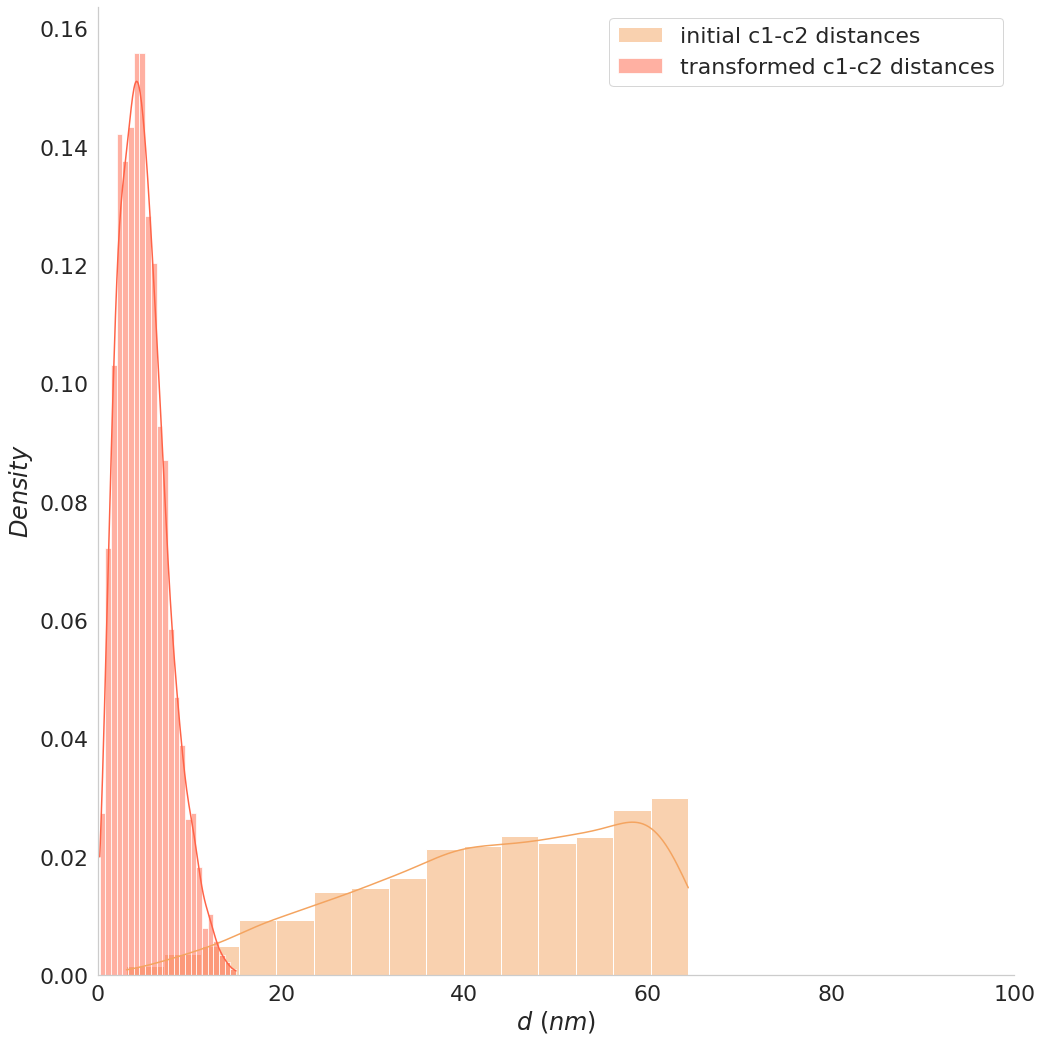

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [24]:
######################
# 3. Calculate TRE
######################
plot_distance_distribution(path_output_test, c2_test, c1_test, c1_test_new, px_size=px_size)
calculate_tre(path_output_test, c2_test, c1_test, c1_test_new, px_size=px_size)

## END
